# Import libraries, read datasets

In [27]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import catboost as cb
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
from sklearn.mixture import GaussianMixture 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder



In [28]:
df1 = pd.read_csv('datasets/bcsc_risk_factors_expanded1.csv')
df2 = pd.read_csv('datasets/bcsc_risk_factors_expanded2.csv')
df3 = pd.read_csv('datasets/bcsc_risk_factors_expanded3.csv')

In [29]:
#slight cleaning
df = pd.concat([df1, df2, df3])
df = df[df.ne(9).all(1)] #drop unknowns (9s)
df.drop(['year'], axis=1, inplace=True)

# Preprocess

## Balance data

<Axes: xlabel='breast_cancer_history'>

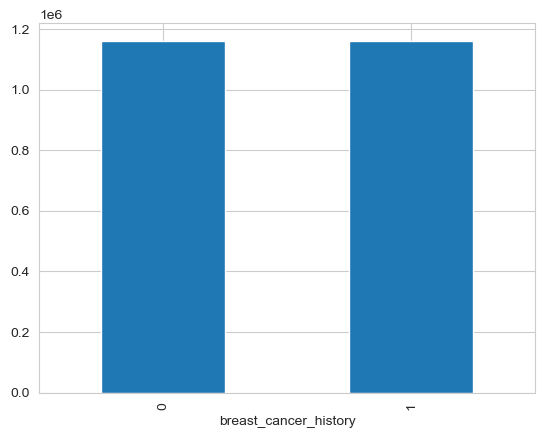

In [8]:
#since GMM doesn't have class_weight attribute, have to balance dataset first

# Identify the minority class
minority_class = df['breast_cancer_history'].value_counts().idxmin()
majority_class = df['breast_cancer_history'].value_counts().idxmax()

# Calculate how many samples to duplicate
samples_to_add = df['breast_cancer_history'].value_counts()[majority_class] - df['breast_cancer_history'].value_counts()[minority_class]

# Duplicate minority class samples
minority_samples = df[df['breast_cancer_history'] == minority_class].sample(n=samples_to_add, replace=True)

# Combine with the original dataset
balanced_df = pd.concat([df, minority_samples])

# Shuffle the dataset to mix the duplicated samples
balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)

#verify
balanced_df.breast_cancer_history.value_counts().plot(kind='bar')

## Scale, Encode

In [9]:
# split data into features (X) and labels (y)
#may need to drop biophx
X = balanced_df.drop('breast_cancer_history', axis=1)
y = balanced_df['breast_cancer_history']

In [10]:
X

,age_group_5_years,race_eth,first_degree_hx,age_menarche,age_first_birth,BIRADS_breast_density,current_hrt,menopaus,bmi_group,biophx
0,10,2,1,1,2,3,0,2,4,0
1,4,5,1,2,0,3,0,1,1,1
2,4,5,0,0,2,3,0,1,2,1
3,8,1,0,0,0,3,0,2,1,0
4,6,1,0,0,4,3,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...
2323449,7,1,0,1,1,2,0,2,2,0
2323450,10,2,0,2,0,2,0,2,3,0
2323451,7,3,0,1,2,3,0,2,1,0
2323452,10,2,0,1,1,3,0,2,2,1


In [16]:
#scale since one col is years, some cols go from 0-13, some from 0-2, etc
encoder = OneHotEncoder()


scaler = StandardScaler()
all_cols = balanced_df.columns.tolist()
numeric_cols = [col for col in all_cols]
numeric_cols.remove('breast_cancer_history')

#column transformer to preprocess corresponding columns
transformer = ColumnTransformer(
        [('numeric', scaler, numeric_cols)],
        remainder='drop', verbose_feature_names_out=False)


## Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [18]:
y_test.value_counts()

breast_cancer_history
1    290586
0    290278
Name: count, dtype: int64

# Clustering methods

## PCA

Text(0.5, 1.0, 'Variance Explained by each Principle Component')

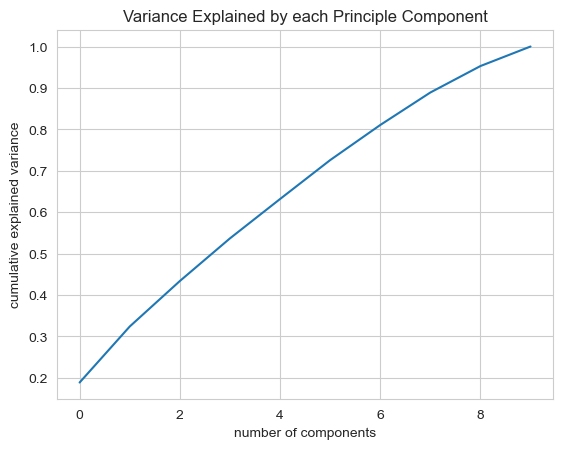

In [10]:
pca = Pipeline([('transform', transformer), #need to use transfomer since have both categorical and numeric data
                         ('pca', PCA(10))]) #first start with most of the features

pca.fit(X_train) 

pca['pca']

plt.plot(np.cumsum(pca['pca'].explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');


plt.title('Variance Explained by each Principle Component')

#need roughly 8 variables to explain 90% of variance

In [11]:
pca_pipeline = Pipeline([('transform', transformer),
                         ('pca', PCA(8)),
                         ('RF', RandomForestClassifier(class_weight='balanced', criterion='gini', max_depth=100, min_impurity_decrease= 0.0, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 10, random_state= 1, verbose=0))]) #found this from below

pca_pipeline.fit(X_train, y_train)

y_pred = pca_pipeline.predict(X_test)

sum(y_pred == y_test)/len(y_test)

#0.8768317540766858!

0.8193088227192595

### Kmeans with PCA

In [12]:
kmeans_pca_pipeline = Pipeline([('transform', transformer),
                                ('pca', PCA(n_components=2))])

X_train_trans = kmeans_pca_pipeline.fit_transform(X_train)

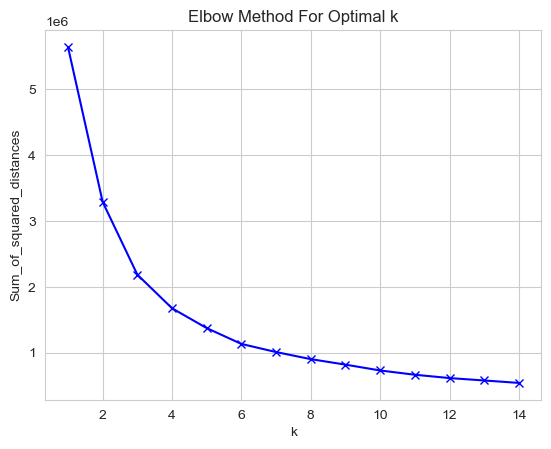

In [13]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_train_trans)
    Sum_of_squared_distances.append(km.inertia_)
#Visualing the plot
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#not a very good elbow curve. can start with two since know that's how many groups there are

In [14]:
# Fit and plot the data for each k value
#for k in k_range:
kmeans = KMeans(n_clusters=2,
                init='k-means++', random_state=42)
kmeans_pca = kmeans.fit(X_train_trans) #do I need this?
y_kmeans = kmeans.fit_predict(X_train_trans)

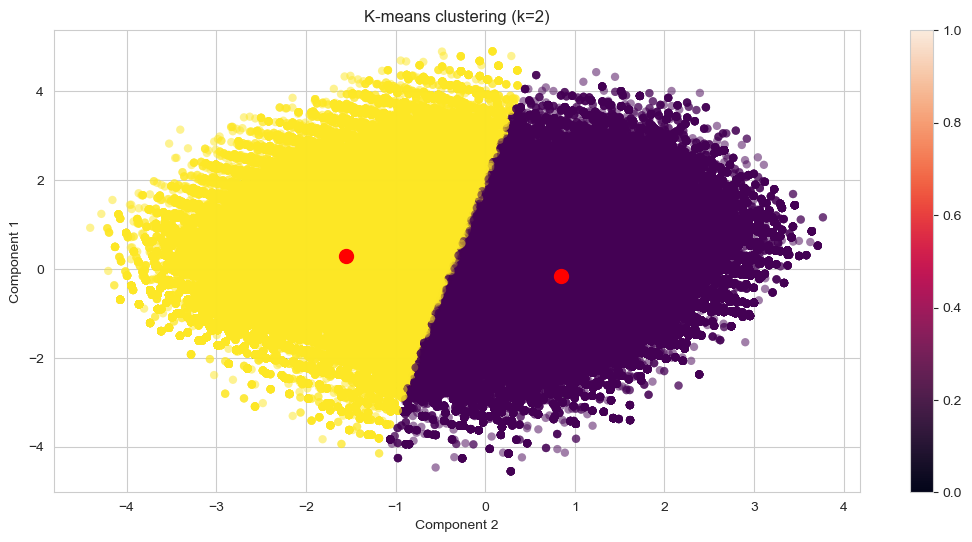

In [15]:
plt.figure(figsize=(13,6))
plt.scatter(X_train_trans[:, 0], X_train_trans[:, 1], 
            c=y_kmeans, edgecolor='none', 
            alpha=0.5, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0],\
            kmeans.cluster_centers_[:, 1], \
            s=100, c='red')
plt.title('K-means clustering (k=2)'.format(k))
plt.xlabel('Component 2')
plt.ylabel('Component 1')
plt.colorbar()
plt.show()

### Another way of doing KMeans with PCA

In [30]:
nclusters = 2 

In [31]:
# first define a plot fn

def plotData(df, groupby):
    # Make a scatterplot of the first two principal components of the data, colored by the groupby field.

    plt.figure(figsize=(7, 7))
    
    # Use seaborn scatterplot with hue for coloring by group
    sns.scatterplot(data=df, x='PC1', y='PC2', hue=groupby, palette='tab10', s=30)
    
    plt.axhline(0, color='black')
    plt.axvline(0, color='black')
    plt.title("Principal Components Analysis (PCA)")
    plt.grid(True)
    plt.legend(title=groupby)
    plt.show()

In [32]:
X_pca = pd.DataFrame(X_train_trans, columns=['PC1','PC2']) 
X_pca.sample(5)

,PC1,PC2
1176621,-0.089855,-0.911160
1083833,-0.588855,-2.085669
1714585,-0.329553,-2.438487
1500642,-2.042609,0.714233
564555,1.010131,0.907392


In [33]:
df_plot = X_pca.copy()
df_plot['ClusterKmeans'] = y_kmeans
df_plot['breast_cancer_history'] = y
df_plot.sample(5)

,PC1,PC2,ClusterKmeans,breast_cancer_history
1214382,-2.043023,-0.752576,1,1
1124599,-0.377207,-1.349349,0,1
927636,2.077557,1.855073,0,0
1215814,1.724591,0.499469,0,0
1581142,1.704437,0.778280,0,1


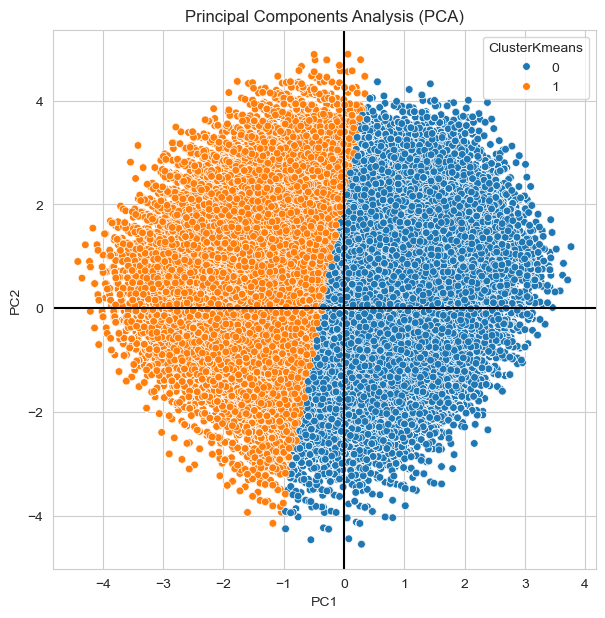

In [34]:
plotData(df_plot, 'ClusterKmeans') #confirms what we saw above

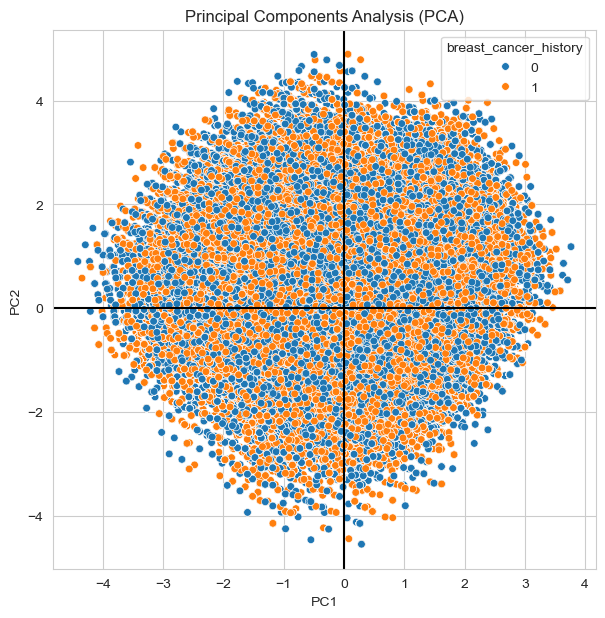

In [35]:
#actual labels
plotData(df_plot, 'breast_cancer_history')

### GMM with PCA

In [36]:
#gmm
nclusters=2 #since either 0 or 1
gmm = GaussianMixture(n_components=nclusters)
gmm.fit(X_train)

# predict the cluster for each data point
y_cluster_gmm = gmm.predict(X_train)
y_cluster_gmm


array([1, 0, 0, ..., 1, 1, 1])

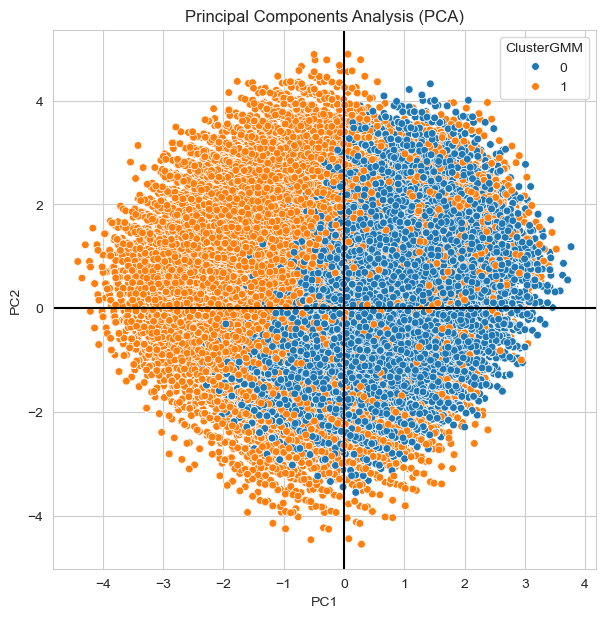

In [37]:
df_plot['ClusterGMM'] = y_cluster_gmm
plotData(df_plot, 'ClusterGMM')

## TSNE - SO SLOW!! stopped it at 4min

In [ ]:
# Perform t-SNE
tsne = TSNE(n_components=2,
           perplexity=16,
           early_exaggeration=1,
           learning_rate=10)
X_tsne = tsne.fit_transform(X_train)

# Plot the results
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train)
plt.title("t-SNE")
plt.show()


# Ensemble - Supervised Learning

## Random forest, SVM, CatBoost, and Logisitic Regression

### Preprocess

In [13]:
#set up standard scaler
std_scaler = StandardScaler()
all_cols = df.columns.tolist()
all_cols.remove('breast_cancer_history')

In [14]:
#take random sample (to make ensemble run faster) and standard scale for the ensemble
df_sample = df.sample(frac=.2)
std_scaler.fit_transform(df_sample)

array([[ 0.57787674, -1.17904068, -0.57637355, ..., -1.01068621,
        -0.55097899, -0.24632325],
       [-0.51932998,  0.51462447,  0.9812272 , ..., -1.01068621,
        -0.55097899, -0.24632325],
       [ 0.85217842, -0.75562439, -0.57637355, ...,  0.90584034,
        -0.55097899, -0.24632325],
       ...,
       [ 0.57787674,  2.20828963, -0.57637355, ..., -1.01068621,
         1.81495124,  4.05970611],
       [-1.89083838,  0.51462447,  0.20242683, ..., -0.05242294,
        -0.55097899, -0.24632325],
       [ 0.30357506, -0.75562439, -0.57637355, ..., -1.01068621,
        -0.55097899, -0.24632325]])

In [15]:
#split
X_sam = df_sample[all_cols]
y_sam = df_sample['breast_cancer_history'] 

X_train_sam, X_test_sam, y_train_sam, y_test_sam = train_test_split(X_sam, y_sam, random_state=0)

In [16]:
cv = RepeatedStratifiedKFold(n_repeats=3, random_state=1)

In [ ]:
#don't run this unless you want to wait for 8 min lol


#set up ensemble with models that would work well classifying categorical, non-gaussian data
clf1 = LogisticRegression(class_weight='balanced') 
clf2 = RandomForestClassifier(random_state=1, class_weight='balanced') 
clf3 = CatBoostClassifier(auto_class_weights='Balanced')

#ensemble
eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('boost', clf3)],
    voting='hard')

#find accuracies using cross validated scores
for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'Cat Boost', 'Ensemble']):
    scores = cross_val_score(clf, X_train_sam, y_train_sam, scoring='accuracy', cv=cv)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))


#result: go with random forest
#Accuracy: 0.76 (+/- 0.00) [Logistic Regression]
#Accuracy: 0.90 (+/- 0.00) [Random Forest]
#ccuracy: 0.78 (+/- 0.00) [Cat Boost]
#Accuracy: 0.80 (+/- 0.00) [Ensemble]

## Move forward with random forest

### Hyperparameterize

In [35]:
#set model, find names of parameters
rf =  RandomForestClassifier(random_state=1, class_weight='balanced')
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

In [36]:
# not random search since have to have some specific ones for criterion
parameters = {
    'max_depth': (5,10,100,200),
    'n_estimators': (10,100,200,500),
    'criterion': ('gini', 'log_loss', 'entropy')
}

#apply to model
grid_search = GridSearchCV(rf, parameters, cv=3, n_jobs=-1, verbose=1)

#fit
grid_search.fit(X_train_sam, y_train_sam) #use just sample data d/t speed

#find best score and parameter
grid_search.best_estimator_.get_params() 

# {'bootstrap': True, 
# 'ccp_alpha': 0.0,
#  'class_weight': 'balanced',
#  'criterion': 'gini',
#  'max_depth': 100,
#  'max_features': 'sqrt',
#  'max_leaf_nodes': None,
#  'max_samples': None,
#  'min_impurity_decrease': 0.0,
#  'min_samples_leaf': 1,
#  'min_samples_split': 2,
#  'min_weight_fraction_leaf': 0.0,
#  'monotonic_cst': None,
#  'n_estimators': 10,
#  'n_jobs': None,
#  'oob_score': False,
#  'random_state': 1,
#  'verbose': 0,
#  'warm_start': False}

grid_search.best_score_  #0.9071816997029319


Fitting 3 folds for each of 48 candidates, totalling 144 fits


/opt/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


0.9054460381261483

### Split whole ds

In [29]:
#split - don't use!!

# X = df[all_cols]
# y = df['breast_cancer_history'] 

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [4]:
#got bad confusion matrix when just used class_weights='balanced' so will try this method instead

def split_and_balance(data):
    X_train, X_test, y_train, y_test = train_test_split(data, data['breast_cancer_history'], stratify = data['breast_cancer_history'], random_state=42) 
    X_train_ca = X_train[X_train['breast_cancer_history'] == 1]
    X_train_no_ca = X_train[X_train['breast_cancer_history'] == 0]
    num_matches = X_train_ca['breast_cancer_history'].count()
    X_train_no_ca = X_train_no_ca.sample(n=num_matches)

    X_train_no_ca.shape

    X_train_final = pd.concat([X_train_ca, X_train_no_ca])

    y_train_final = X_train_final['breast_cancer_history']
    X_train_final = X_train_final.loc[:, X_train_final.columns != 'breast_cancer_history']

    X_test = X_test.loc[:, X_test.columns != 'breast_cancer_history']

    return X_train_final, y_train_final, X_test, y_test

In [19]:
X_train_final, y_train_final, X_test, y_test = split_and_balance(df)

In [20]:
X_train_final

,age_group_5_years,race_eth,first_degree_hx,age_menarche,age_first_birth,BIRADS_breast_density,current_hrt,menopaus,bmi_group,biophx
1456178,12,1,1,1,2,2,0,2,4,1
1032587,8,1,0,0,4,3,0,2,3,1
1495402,8,1,1,0,0,3,0,2,1,0
2309708,12,1,0,2,1,2,0,2,3,0
1773235,8,1,0,2,4,2,0,2,3,1
...,...,...,...,...,...,...,...,...,...,...
59588,8,1,0,1,1,1,0,2,2,0
1645400,10,1,0,2,1,2,0,2,3,1
2153457,6,1,1,1,4,3,0,2,1,0
799481,4,1,0,1,3,2,0,1,1,0


### Set up pipeline

In [21]:
#set up pipeline
classification_pipeline = Pipeline([('std_scale', std_scaler),
                                    ('RF', RandomForestClassifier(class_weight='balanced', criterion='gini', max_depth=100, min_impurity_decrease= 0.0, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 10, random_state= 1, verbose=0))])

classification_pipeline.fit(X_train_final, y_train_final)

NameError: name 'std_scaler' is not defined

### Cross validate

In [41]:
#cross validate
scores = cross_val_score(classification_pipeline, X_train_final, y_train_final, cv=5)
print(scores.mean(), '\t', scores.std())

# 0.7469064521838191 	 0.0032946865092970037


0.7692120218820112 	 0.003281641513876768


### Test data

In [42]:
#fit and predict
classification_pipeline.fit(X_train_final, y_train_final)
classification_pipeline.predict(X_test)

array([1, 1, 0, ..., 0, 0, 1])

In [43]:
#find accuracy
y_pred = classification_pipeline.predict(X_test)
sum(y_pred == y_test) / len(y_test)
#0.7419429142415925

0.7489829287758161

### Confusion matrix

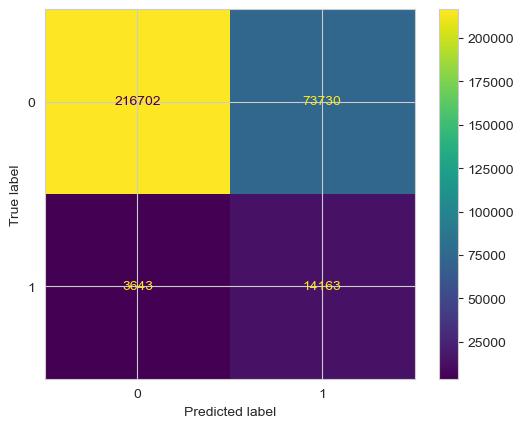

In [44]:
disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred), display_labels=classification_pipeline.classes_)

disp.plot()

### Add column of probability

In [43]:
df_x.columns

Index(['year', 'age_group_5_years', 'race_eth', 'first_degree_hx',
       'age_menarche', 'age_first_birth', 'BIRADS_breast_density',
       'current_hrt', 'menopaus', 'bmi_group', 'biophx',
       'breast_cancer_probability'],
      dtype='object')

In [46]:
#drop true result
df_x = df.drop(['breast_cancer_history'], axis=1)

#predict probability of having breast ca
probabilities = classification_pipeline.predict_proba(df_x)[:, 1]  # Assuming breast cancer is the positive class

# Add the probabilities to the DataFrame
df_x['breast_cancer_probability'] = probabilities

#merge probabilities with actual results
df_total = df_x.copy()
df_total['breast_cancer_history'] = df['breast_cancer_history']

In [47]:
# Display the updated DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df_total.head(10)

,age_group_5_years,race_eth,first_degree_hx,age_menarche,age_first_birth,BIRADS_breast_density,current_hrt,menopaus,bmi_group,biophx,breast_cancer_probability,breast_cancer_history
15100,7,1,1,0,0,1,0,2,3,0,0.000000,0
15101,7,1,1,0,0,1,0,2,3,0,0.000000,0
15102,7,1,1,0,0,1,0,2,4,1,0.500000,0
15103,7,1,1,0,0,1,0,3,2,1,0.700000,0
15104,7,1,1,0,0,1,0,3,4,0,0.140000,0
15105,7,1,1,0,0,2,0,1,3,0,0.133333,0
15106,7,1,1,0,0,2,0,1,4,1,1.000000,1
15107,7,1,1,0,0,2,0,2,1,0,0.670238,0
15108,7,1,1,0,0,2,0,2,1,1,0.450000,0
15109,7,1,1,0,0,2,0,2,1,1,0.450000,0


# Neural Network - Unsupervised Learning

## Preprocess

In [34]:
#label encode year
X_year = X['year']
X_year = pd.DataFrame(X_year)
label_encode = LabelEncoder()
X_year_encode = label_encode.fit_transform(X_year)

/Users/Haleigh/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [30]:
#standard scale the rest
#X_rest = X.drop('year', axis=1)
scaler2 = StandardScaler()
X_rest_scale = scaler2.fit_transform(X)

In [12]:
#join all cols back
X_year_encode = pd.DataFrame(X_year_encode, columns=X_year.columns)
y = pd.DataFrame(y)
X_rest_scale = pd.DataFrame(X_rest_scale, columns=X_rest.columns)

df_scale = pd.concat([X_rest_scale, X_year_encode, y], axis=1)


NameError: name 'X_year_encode' is not defined

In [31]:
#split
train_data, test_data = train_test_split(X_rest_scale, test_size=0.2, random_state=42)

In [32]:
train_data

array([[ 0.88244274,  0.28257921, -0.49410736, ...,  0.38436448,
        -0.05575097, -0.91456905],
       [-1.0402747 ,  2.7556962 , -0.49410736, ...,  2.21740777,
        -0.05575097, -0.91456905],
       [ 0.11335577, -0.54179312,  2.02385166, ...,  0.38436448,
         0.91412582,  1.09341116],
       ...,
       [ 1.26698623, -0.54179312, -0.49410736, ...,  0.38436448,
        -1.02562775,  1.09341116],
       [ 0.88244274, -0.54179312, -0.49410736, ...,  0.38436448,
        -0.05575097, -0.91456905],
       [-0.65573121, -0.54179312, -0.49410736, ...,  0.38436448,
        -1.02562775, -0.91456905]])

### Make NN

In [33]:
# Define a custom PyTorch dataset
class Ca_Dataset(Dataset):
    def __init__(self, data):
        self.X = data[[col for col in all_cols if col != "breast_cancer_history"]].values  # Exclude target column
        self.y = data["breast_cancer_history"].values
        self.n_samples = len(data)

    def __getitem__(self, index):
        return torch.tensor(self.X[index], dtype=torch.float32), torch.tensor(self.y[index], dtype=torch.int64)

    def __len__(self):
        return self.n_samples

In [34]:
train_data

array([[ 0.88244274,  0.28257921, -0.49410736, ...,  0.38436448,
        -0.05575097, -0.91456905],
       [-1.0402747 ,  2.7556962 , -0.49410736, ...,  2.21740777,
        -0.05575097, -0.91456905],
       [ 0.11335577, -0.54179312,  2.02385166, ...,  0.38436448,
         0.91412582,  1.09341116],
       ...,
       [ 1.26698623, -0.54179312, -0.49410736, ...,  0.38436448,
        -1.02562775,  1.09341116],
       [ 0.88244274, -0.54179312, -0.49410736, ...,  0.38436448,
        -0.05575097, -0.91456905],
       [-0.65573121, -0.54179312, -0.49410736, ...,  0.38436448,
        -1.02562775, -0.91456905]])

In [35]:
# Create PyTorch datasets and dataloaders
train_dataset = Ca_Dataset(train_data)
test_dataset = Ca_Dataset(test_data)

train_loader = DataLoader(dataset=train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=10, shuffle=True)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [55]:
# Define a simple neural network with one hidden layer
class Ca_NN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Ca_NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [56]:
# Initialize the model, loss function, and optimizer
input_size = 11 #number of features
hidden_size = 64
num_classes = 2
learning_rate = 0.001

model = Ca_NN(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [57]:
# Training loop
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/5, Loss: 0.4825
Epoch 2/5, Loss: 0.4800
Epoch 3/5, Loss: 0.4792
Epoch 4/5, Loss: 0.4787
Epoch 5/5, Loss: 0.4783


In [58]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = correct / total
print(f"Accuracy on test set: {accuracy:.2%}")

#Accuracy on test set: 77.97%

Accuracy on test set: 77.97%


### Need to redo with balanced class weights